In [1]:
import pandas as pd
import altair as alt
import numpy as np
# Handle large data sets without embedding them in the notebook
alt.data_transformers.enable('data_server')
# Gradescope only supports displaying plots as images
alt.renderers.enable('mimetype')

RendererRegistry.enable('mimetype')

In [2]:
# Load data
df = pd.read_csv('../../data/raw/abalone.data', names = ['sex',
                                          'length',
                                          'diameter',
                                          'height',
                                          'whole_weight',
                                          'shucked_weight',
                                          'viscera_weight',
                                          'shell_weight',
                                          'rings'])

# Add a classification target columns. If rings > 10, then classified as old
df['is_old'] = np.where(df['rings'] > 10, 'old', 'young')
df

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings,is_old
0,0,1.000,2.000,3.000,4.0000,5.0000,6.0000,7.0000,8,young
1,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15,old
2,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7,young
3,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9,young
4,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10,young
...,...,...,...,...,...,...,...,...,...,...
4173,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11,old
4174,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10,young
4175,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9,young
4176,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10,young


In [3]:
# train test split
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size = 0.2, random_state = 123)

### Data summary table
We have 3342 observations in the training data set and there is no missing value in it. The descriptive data analysis is shown in the table.

In [11]:
train_df.describe()

,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
count,3342.000000,3342.000000,3342.000000,3342.000000,3342.000000,3342.000000,3342.000000,3342.000000
mean,0.524126,0.408321,0.140411,0.830174,0.360782,0.182722,0.241054,9.928785
std,0.120410,0.102957,0.065398,0.493401,0.235642,0.149106,0.181691,3.212472
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.441500,0.188500,0.093000,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.799250,0.334500,0.170250,0.235000,9.000000
75%,0.615000,0.480000,0.165000,1.154375,0.505500,0.255500,0.330000,11.000000
max,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,29.000000


### Target variables distribution
We can observe a slightly right skewed distribution of `rings`. We set the threshold for old abalone as `rings > 10` and we get an unbalanced distribution of old and young abalone.

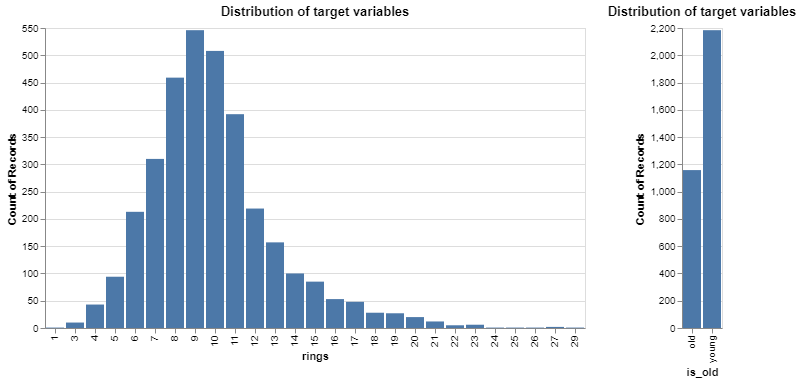

In [4]:
# Distribution of our target: rings and is_old
alt.Chart(train_df, title = 'Distribution of target variables').mark_bar().encode(
    alt.X(alt.repeat(), type='nominal'),
    alt.Y('count()')
).repeat(
    ['rings', 'is_old']
)

### Distribution of categorical variable
The distribution of sex is balanced.

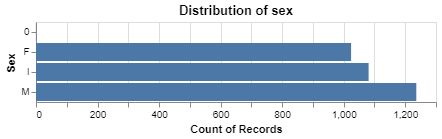

In [5]:
# Distribution of categorical variable: sex
alt.Chart(train_df, title = 'Distribution of sex').mark_bar().encode(
    alt.Y('sex', title = 'Sex'),
    alt.X('count()')
)

### Distribution of continuous variables
From the plot we can group the numeric variables into three groups: (length, diameter), (height), and (whole_weight, shucked_weight, viscera_weight, shell_weight). The first group is left skewed, the second group has some outliers and the third group is right skewed. By the distribution and common knowledge we can infer that variables in the first and third groups are highly correlated.

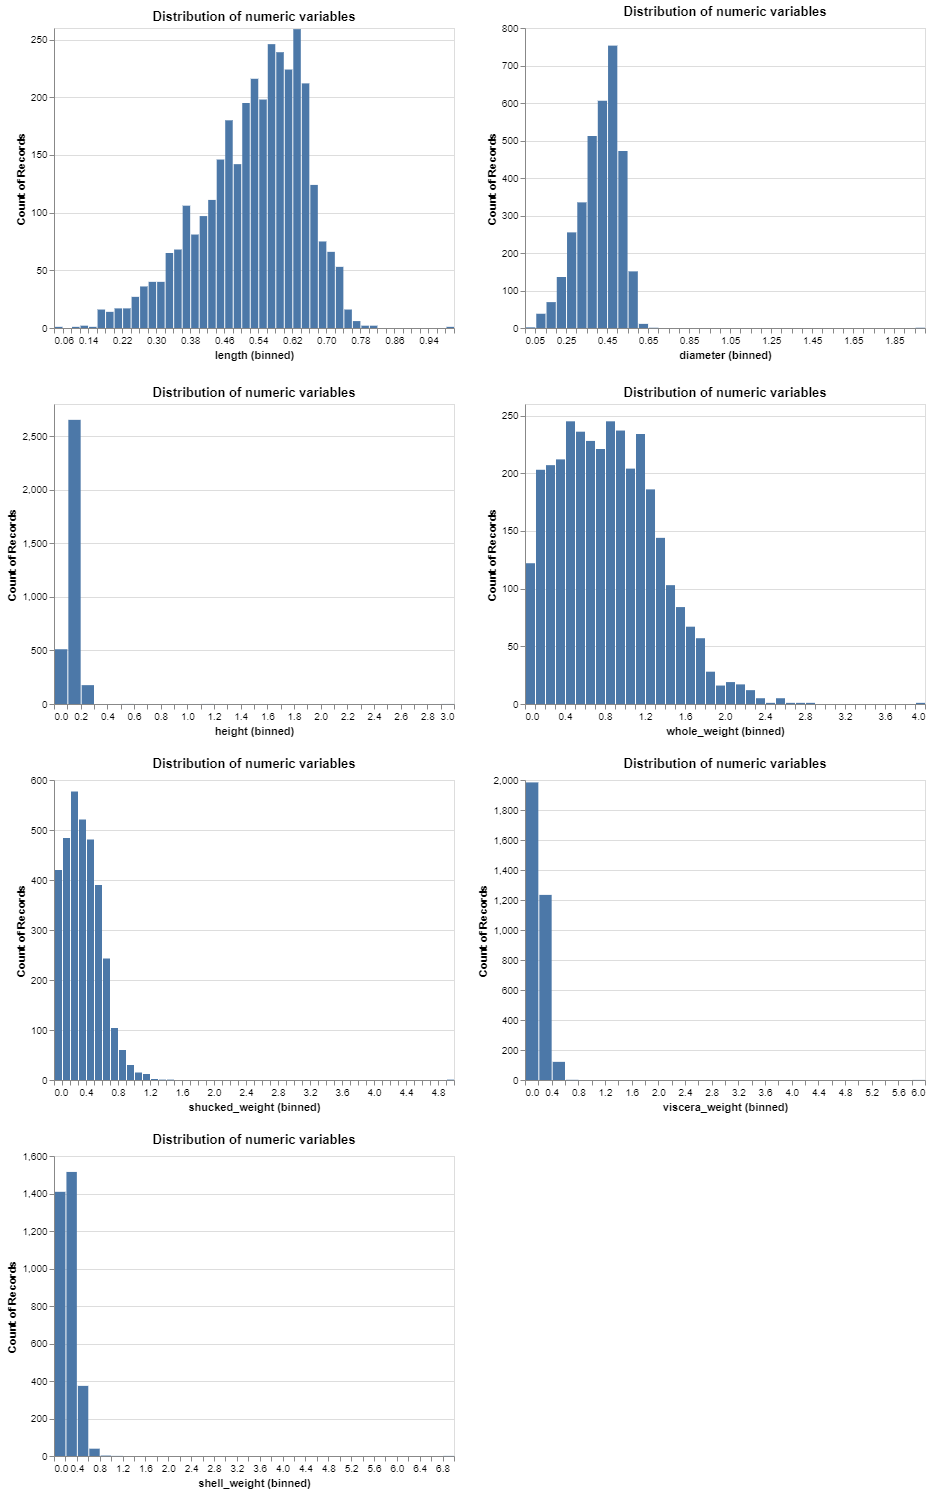

In [6]:
# Distribution of numeric variables: 'length', 'diameter', 'height', 'whole_weight', 'shucked_weight', 'viscera_weight', 'shell_weight'
alt.Chart(train_df, title = 'Distribution of numeric variables').mark_bar().encode(
    alt.X(alt.repeat(), type='quantitative', bin = alt.Bin(maxbins = 50)),
    alt.Y('count()')
).repeat(
    ['length',
     'diameter',
     'height',
     'whole_weight',
     'shucked_weight',
     'viscera_weight',
     'shell_weight'],
    columns = 2
)

### Correlation heat map
From the heat map we can tell that feature variables are highly correlated.

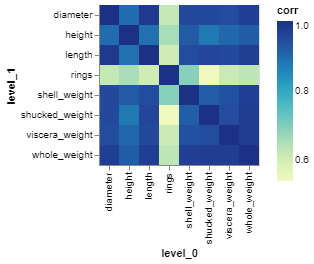

In [7]:
# check colinearity in features
corr_df = (
    train_df.drop(['sex', 'is_old'], axis = 1)
    .corr('spearman')
    .abs()
    .stack()
    .reset_index(name='corr'))
alt.Chart(corr_df).mark_rect().encode(
    x='level_0',
    y='level_1',
    size='corr',
    color='corr')

### Correlation between one of each feature variables from each group
We can observe that the length, height and weight of a young abalone is positively correlated with the rings. As of an old abalone, we can only observe a positive correlation in height.

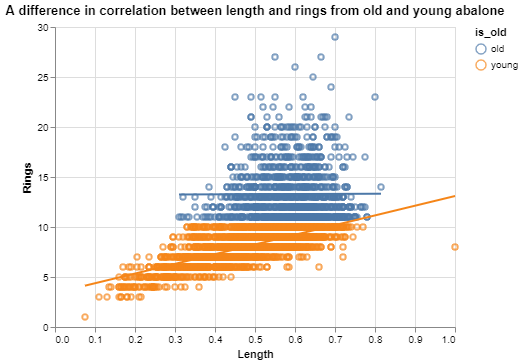

In [8]:
point_length = alt.Chart(train_df,
                         title = 'A difference in correlation between length and rings from old and young abalone'
                        ).mark_point().encode(
    x = alt.X('length', title = 'Length'),
    y = alt.Y('rings', title = 'Rings'),
    color = 'is_old'
)
point_length + point_length.transform_regression('length', 'rings', groupby = ['is_old']).mark_line(color = 'red')

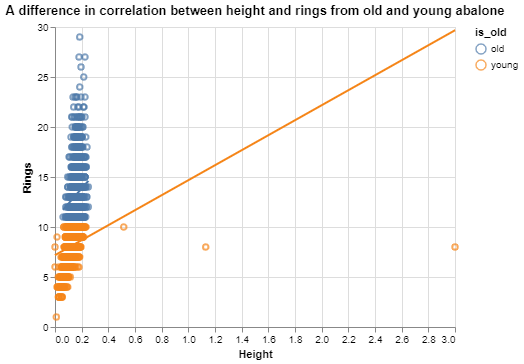

In [9]:
point_height = alt.Chart(train_df,
                         title = 'A difference in correlation between height and rings from old and young abalone'
                        ).mark_point().encode(
    x = alt.X('height', title = 'Height'),
    y = alt.Y('rings', title = 'Rings'),
    color = 'is_old'
)
point_height + point_height.transform_regression('height', 'rings', groupby = ['is_old']).mark_line(color = 'red')

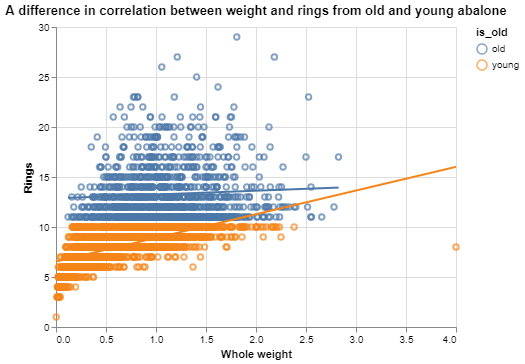

In [10]:
point_weight = alt.Chart(train_df,
                         title = 'A difference in correlation between weight and rings from old and young abalone'
                        ).mark_point().encode(
    x = alt.X('whole_weight', title = 'Whole weight'),
    y = alt.Y('rings', title = 'Rings'),
    color = 'is_old'
)
point_weight + point_weight.transform_regression('whole_weight', 'rings', groupby = ['is_old']).mark_line(color = 'red')